
---

# Natural Language Processing project

---


### Tristan Basler - Clément Boulay <br>
CentraleSupélec

### Setting up a Multi-Layer Perceptron (MLP) for Dialog-Act prediction

### Requirements

We suggest that you run this notebook in <a href="https://colab.research.google.com">Google Colab</a>. 

In [ ]:
# if working in Colab, you will need the following installs
!pip install torchtext
!pip install datasets
!pip install torchinfo

In [2]:
from datasets import load_dataset
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from torchtext.vocab import GloVe, vocab, FastText

In [ ]:
# init a TensorBoard writer
writer = SummaryWriter()

### Fetching the dataset from HuggingFace

Please refer to the notebook `utils.ipynb` for an extensive dataset exploration.

In [3]:
# download the DailyDialog Act Corpus  from Silicon Dataset from HuggingFace
dataset = load_dataset("silicone", "dyda_da")

Generating train split:   0%|          | 0/87170 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8069 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7740 [00:00<?, ? examples/s]

Dataset silicone downloaded and prepared to /root/.cache/huggingface/datasets/silicone/dyda_da/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Defining the `SiliconeDataset` Class

In [4]:
class SiliconeDataset(Dataset):
    """
    Class used for convenient handling of the dyda_da corpus from the Silicone Dataset.
    """
    def __init__(self, data):
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, index):
      return self.data[index]

### Data preprocessing

There is a bunch of preprocessing actions we shall perform on the dataset utterances before being able to define and train a Deep Learning model. <br>
First, we need to pad or clip utterances to a fixed length, as the neural nets we are going to implement do not handle sequences with varying length. <br>
Second, we need to tokenize utterances, at a level that will be discussed thereafter, using a pre-defined vocabulary. In our case, we will use Word2Vec embeddings. <br>

#### Sequence padding/clipping, tokenizing and embedding

In [5]:
class UnsupportedTokenizingMethodError(Exception):
  """
  Exception raised when an unsupported tokenizing method is queried in the preprocessing pipeline. 
  """
  def __init__(self):
    super().__init__()
    pass

In [6]:
class UnsupportedEmbeddingMethodError(Exception):
  """
  Exception raised when an unsupported embedding method is queried in the preprocessing pipeline. 
  """
  def __init__(self):
    super().__init__()
    pass

In [30]:
class PreprocessingPipeline():
  """
  Class that implements the full preprocessing pipeline.
  """
  def __init__(self,  tokenizer_used: str = "treebank", embedding_method: str = "fasttext", max_length: int = 20):

    self.max_length = max_length
    self. supported_tokenizers = ["tweet", "treebank"]
    self.supported_embeddings = ["fasttext", "glove"]

    if tokenizer_used not in self.supported_tokenizers:
      raise UnsupportedTokenizingMethodError
    if tokenizer_used == "tweet":
      self.tokenizer = TweetTokenizer()
    elif tokenizer_used == "treebank":
      self.tokenizer = TreebankWordTokenizer()

    if embedding_method not in self.supported_embeddings:
      raise UnsupportedTokenizingMethodError
    else:
      self.embedding_method = embedding_method
    if self.embedding_method == "fasttext":
      self.pretrained_vectors = FastText(language='en')
    elif self.embedding_method == "glove":
      self.pretrained_vectors = GloVe(name="6B", dim='300')
    
    # get the vocabulary that corresponds to the used embeddings
    self.pretrained_vocab = vocab(self.pretrained_vectors.stoi)

    # add the <unk> and <pad> tokens to the vocabulary
    unk_token = "<unk>"
    unk_index = 0
    pad_token = '<pad>'
    pad_index = 1
    self.pretrained_vocab.insert_token("<unk>",unk_index)
    self.pretrained_vocab.insert_token("<pad>", pad_index)
    self.pretrained_vocab.set_default_index(unk_index)

    self.vocab_stoi = self.pretrained_vocab.get_stoi()

  def clip_or_pad_sequence(self, tokenized_input_sequence: list):
    """
    Perform a padding or clipping operation on the tokenized input sequence, depending on its length. 
    """
    if len(tokenized_input_sequence) == self.max_length:
      return tokenized_input_sequence
    elif len(tokenized_input_sequence) < self.max_length:
      # need to pad the tokenized sequence up to max_length
      padded_sequence = tokenized_input_sequence + [self.vocab_stoi['<pad>'] for i in range(len(tokenized_input_sequence), self.max_length)]
      return padded_sequence
    else:
      clipped_sequence = tokenized_input_sequence[:self.max_length]
      return clipped_sequence

  def tokenize_input_sequence(self, input_sequence: str):
    """ 
    Tokenize the input_sequence using the tokenazing_method.
    """
    tokenized_sequence = [self.vocab_stoi[token] if token in self.vocab_stoi else self.vocab_stoi['<unk>'] for token in self.tokenizer.tokenize(input_sequence.lower())]
    return tokenized_sequence

  def preprocess_input(self, input_sequence: str ):
    """
    Define the whole data preprocessing pipeline. 
    """
    tokenized_input_sequence  = self.tokenize_input_sequence(input_sequence)
    clipped_sequence = self.clip_or_pad_sequence(tokenized_input_sequence)
    return clipped_sequence

In [ ]:
preprocessing_pipeline = PreprocessingPipeline(embedding_method="glove")

In [9]:
# testing the preprocessing pipeline
test_seq = "I love natural language processing."
preprocessed_seq = preprocessing_pipeline.preprocess_input(test_seq)

In [10]:
preprocessed_seq

[42, 836, 1133, 1033, 4670, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

We see that the original sentence has been padded to match a length of 20. The chosen tokenizer (TreebankWordTokenizer) has also kept the dot at the end of the utterance for embedding. The <pad> token index in the vocabulary is 1, which is correct since we have inserted in beforehand.

In [11]:
# testing the preprocessing pipeline
test_seq_2 = "France has got the best cheese in the world, which is why so many tourists come to France for their annual vacation."
preprocessed_seq_2 = preprocessing_pipeline.preprocess_input(test_seq_2)

In [12]:
preprocessed_seq_2

[388,
 32,
 406,
 0,
 255,
 5796,
 7,
 0,
 86,
 2,
 43,
 15,
 739,
 101,
 110,
 2698,
 327,
 5,
 388,
 11]

In [13]:
print("Length of the original utterance was {} but the length of the preprocessed sequence is {}".format(len(test_seq_2.split(" ")), len(preprocessed_seq_2)))

Length of the original utterance was 22 but the length of the preprocessed sequence is 20


### Preprocessing the Silicon Dataset

In [14]:
def batch_preprocessing(entries):
  """ 
  Apply the preprocessing pipeline to a batch of input utterances.
  """
  preprocessed_batch = {}
  preprocessed_batch["Utterance"] = [preprocessing_pipeline.preprocess_input(entry) for entry in entries['Utterance']]
  preprocessed_batch['Label'] = entries['Label']
  return preprocessed_batch

In [15]:
dataset['train'] = dataset['train'].map(lambda utt: batch_preprocessing(utt), batched=True)

Map:   0%|          | 0/87170 [00:00<?, ? examples/s]

In [16]:
dataset['validation'] = dataset['validation'].map(lambda utt: batch_preprocessing(utt), batched=True)

Map:   0%|          | 0/8069 [00:00<?, ? examples/s]

In [17]:
dataset['test'] = dataset['test'].map(lambda utt: batch_preprocessing(utt), batched=True)

Map:   0%|          | 0/7740 [00:00<?, ? examples/s]

In [18]:
len(dataset['train'])

87170

### Creating DataLoaders

In [19]:
# instanciate the 3 DataLoaders
train_loader = DataLoader(SiliconeDataset(dataset['train']), batch_size=32, num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(SiliconeDataset(dataset['validation']), batch_size=32, num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(SiliconeDataset(dataset['test']), batch_size=32, num_workers=2, shuffle=True, drop_last=True)

### Implementing a simple Multi-Layer Perceptron model

In [20]:
# get the number of classes in the DYDA_DA corpus
classes = list(set(dataset["train"]["Label"]))
nb_classes = len(classes)

In [21]:
# maximal length of input tokenized utterances
max_length = 20 
batch_size = 32
word2vec_dim  = 300

In [22]:
class MultiLayerPerceptron(torch.nn.Module):
  """
  Implement a simple Multi-Layer Perceptron with 2 hidden layers. 
  For documentation on the Linear layer please refer to: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
  """
  def __init__(self, pretrained_vectors):
        super(MultiLayerPerceptron, self).__init__()

        self.name = "Multi-Layer Perceptron model"
        self.hidden_dim = word2vec_dim
        self.output_dim = nb_classes
        self.use_gpu = torch.cuda.is_available()
        if self.use_gpu:
          self.device = 'cuda'
        else:
          self.device = 'cpu'

        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        # self.dropout = nn.Dropout(p=0.01)
        self.linear1 = torch.nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.linear2 = torch.nn.Linear(self.hidden_dim, self.output_dim, bias=True)
        self.softmax = nn.Softmax(dim=1)

  def forward(self, input_tensor):
        """
       The forward method accepts an input Tensor of data and returns an output Tensor. 
       For documentation on the ReLU activation please refer to:  https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        """
        # the input tensor has size (batch_size, max_length)
        ebd = self.ebd(input_tensor)
        # the embedding has size (batch_size, max_length, embedding_dim)
        ebd = ebd.mean(1)
        # take the mean embedding for each input in the batch
        # ebd_regularized =  self.dropout(ebd)
        l1_output = torch.relu(self.linear1(ebd))
        l2_output = self.linear2(l1_output)
        logits = self.softmax(l2_output)
        return logits

  def __str__(self):
      """
      Implement the class behavior when used within a print statement.
      Note: must return a string, hence the below trick.
      For more info on model summary please refer to: https://github.com/TylerYep/torchinfo
      """
      print(summary(self))
      return ""

In [32]:
# in case you need to free some RAM - do not execute if you haven't instantiate the model class yet
del mlp

In [33]:
mlp = MultiLayerPerceptron(preprocessing_pipeline.pretrained_vectors.vectors)
mlp.to(mlp.device)

MultiLayerPerceptron(
  (ebd): Embedding(400000, 300)
  (linear1): Linear(in_features=300, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [34]:
print(mlp)

Layer (type:depth-idx)                   Param #
MultiLayerPerceptron                     --
├─Embedding: 1-1                         (120,000,000)
├─Linear: 1-2                            90,300
├─Linear: 1-3                            1,204
├─Softmax: 1-4                           --
Total params: 120,091,504
Trainable params: 91,504
Non-trainable params: 120,000,000



### Defining training and validation

In [25]:
def run_one_epoch(model, optimizer, epoch_id):
    """
    Function used to train the model for one full epoch.
    For documentation on the loss function used, please refer to: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    """
    # set the model into a training mode: the model's weights and parameters will be updated
    model.train()
    # initialize empty lists for losses and accuracies
    loss_history = []
    accuracy_history = []

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    loss_function = nn.CrossEntropyLoss()

    # start the loop over all the training batches (one full epoch)
    for it, batch in enumerate(train_loader):
      if it%100 == 0:
        print(f"\nBatch: {it}/{len(train_loader)}")
      # print(batch)
      batch_tensors = batch["Utterance"]
      batch_labels = batch["Label"]
      stack_batch =  torch.vstack(batch_tensors)
      stack_batch = torch.transpose(stack_batch, 0, 1)

      batch = {'Utterance': stack_batch.to(model.device), 'Label': batch_labels.to(model.device)}

      # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
      optimizer.zero_grad()
      # apply the model on the batch
      logits = model(batch['Utterance'])

      # compute the loss 
      loss = loss_function(logits, batch['Label'])

      # and run backpropagation
      loss.backward()
      optimizer.step()

      # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
      loss_history.append(loss.item())
      # writer.add_scalar("Training loss", loss.item(), epoch_id)

      # get the predicted tags using the maximum probability from the softmax
      _, dialog_act_predicted  = torch.max(logits, 1)
    
      # compute the accuracy and add it to history
      correct = (dialog_act_predicted.flatten() == batch['Label'].flatten()).float().sum()
      accuracy = correct/batch['Label'].flatten().size(0)
      accuracy_history.append(accuracy.item())

      if it%100 == 0:
         print(f"Training loss: {round(sum(loss_history)/len(loss_history), 3)} \nTraining accuracy: {round(sum(accuracy_history)/len(accuracy_history), 3)}")

    # compute averages of losses and accuracies for this epoch
    loss_average = sum(loss_history)/len(loss_history)
    accuracy_average = sum(accuracy_history)/len(accuracy_history)
  
    # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
    print(f"\nAverage training loss for epoch: {loss_average} \nAverage training accuracy for the epoch: {accuracy_average}")

In [26]:
def inference(set_name, loader, model):
  """
    Run inference, either on the validation set, or on the test set.
  """
  # set the model into a evaluation mode : the model's weights and parameters will not be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_history, accuracy_history, f1_history = [], [], []
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = [], []

  loss_function = nn.CrossEntropyLoss()

  # loop over the loader batches
  for it, batch in enumerate(loader):
    batch_tensors = batch["Utterance"]
    batch_labels = batch["Label"]
    stack_batch =  torch.vstack(batch_tensors)
    stack_batch = torch.transpose(stack_batch, 0, 1)

    with torch.no_grad():
       # do not use compute gradients at validation time; saves computation power and memory
      batch = {'Utterance': stack_batch.to(model.device), 'Label': batch_labels.to(model.device)}

      # apply the model
      logits = model(batch['Utterance'])

      loss = loss_function(logits, batch['Label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_history.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, dialog_act_predicted  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (dialog_act_predicted.flatten() == batch['Label'].flatten()).float().sum()
      acc = correct / batch['Label'].flatten().size(0)
      accuracy_history.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(dialog_act_predicted.cpu().detach().tolist())
      trues.extend(batch['Label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_average = sum(loss_history)/len(loss_history)
  accuracy_average = sum(accuracy_history)/len(accuracy_history)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print(f"\n{set_name} loss: {round(sum(loss_history)/len(loss_history), 3)} \n{set_name} accuracy: {round(sum(accuracy_history) / len(accuracy_history), 3)}")

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_average, accuracy_average, loss_history, accuracy_history

In [28]:
def run_n_epochs(model, learning_rate: float = 0.01, nb_epochs: int = 5, adaptative_learning_rate: bool = False):
  """
  Train the model for n_epochs.
  """
  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)

  # define an empty list to store validation losses for each epoch
  validation_loss_history = []
  # iterate over the number of max epochs set in the arguments
  for epoch in range(nb_epochs):
    print(f"\nEpoch: {epoch + 1}/{nb_epochs}")
    if (epoch > 1) and adaptative_learning_rate:
      # reduce the learning rate for the last 3 epochs
      learning_rate = learning_rate/10 # for adaptative learning rate
    # run a training epoch with the model
    run_one_epoch(model, optimizer, epoch)
    # run inference with the trained model and evaluate its validation performance
    trues, preds, loss_average, accuracy_average, loss_history, accuracy_history= inference("Validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    validation_loss_history.append(loss_average)

  # return the list of epoch validation losses in order to use it later to create a plot
  return validation_loss_history

### Running training (and validation)

In [35]:
validation_loss_history = run_n_epochs(mlp)


Epoch: 1/5

Batch: 0/2724
Training loss: 1.379 
Training accuracy: 0.469

Batch: 100/2724
Training loss: 1.17 
Training accuracy: 0.569

Batch: 200/2724
Training loss: 1.12 
Training accuracy: 0.622

Batch: 300/2724
Training loss: 1.099 
Training accuracy: 0.642

Batch: 400/2724
Training loss: 1.09 
Training accuracy: 0.652

Batch: 500/2724
Training loss: 1.086 
Training accuracy: 0.657

Batch: 600/2724
Training loss: 1.083 
Training accuracy: 0.659

Batch: 700/2724
Training loss: 1.08 
Training accuracy: 0.662

Batch: 800/2724
Training loss: 1.08 
Training accuracy: 0.663

Batch: 900/2724
Training loss: 1.076 
Training accuracy: 0.666

Batch: 1000/2724
Training loss: 1.076 
Training accuracy: 0.667

Batch: 1100/2724
Training loss: 1.074 
Training accuracy: 0.668

Batch: 1200/2724
Training loss: 1.073 
Training accuracy: 0.669

Batch: 1300/2724
Training loss: 1.073 
Training accuracy: 0.67

Batch: 1400/2724
Training loss: 1.071 
Training accuracy: 0.671

Batch: 1500/2724
Training loss

In [36]:
def plot_loss(loss_list):
  '''
  Plot all the losses gathered through the training phase.
  Inputs:
    - loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('Epoch')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Loss function (cross-entropy)')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('Learning rate: {}, optimizer:{}'.format("0.01 - 0.001 (adaptative)", ' Adam'))
  # let's directly show the plot when calling this function
  plt.show()

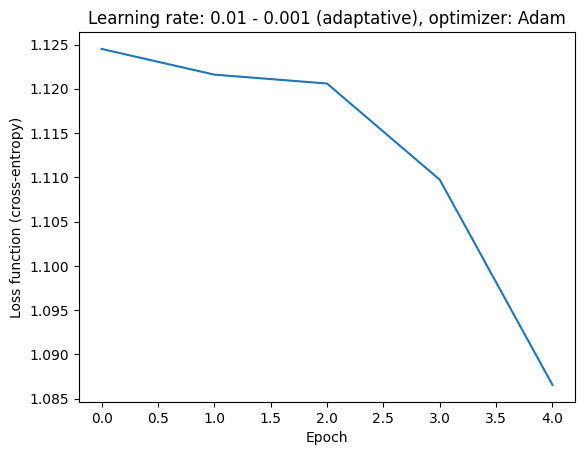

In [37]:
plot_loss(validation_loss_history)

### Running inference

In [38]:
trues, preds, loss_it_avg, cac_it_avg, loss_it, acc_it = inference("Test", test_loader, mlp)


Test loss: 1.032 
Test accuracy: 0.711


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
names = ['__dummy__', 'inform', 'question', 'directive', 'commissive']
names.remove('__dummy__') # dummy label is not interesting
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[1, 2, 3, 4]))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
names = ['__dummy__', 'inform', 'question', 'directive', 'commissive']
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

### Conclusion

To conclude, we can say that we manage to reach an accuracy of 64.2% among the 4 classes of the dataset, which is not that bad regarding the fact that the model (Multi-Layer Perceptron) we used is a simplistic yet powerful model.
To study further the possibilities offered by the model, we could:
- play with the learning rate (here, we defined an adaptative one)
- play with the batch size: large batch sizes have a regularizing effect on the model
- try to perform more epochs, but that might bring us towards overfitting
- define an Early Stopping criterion on the validation performances
- define a (Bi-)LSTM model that better factors the sequential nature of the input data

### Defining a Bi-LSTM model to go beyond the MLP model

In [94]:
class BiLSTM(nn.Module):

    def __init__(self, pretrained_embeddings, freeze_embeddings = True, bidirectionnal: bool = False, num_cells: int = 1):
        '''
        Model class for a Bi-directionnal LSTM model.
        '''
        super(BiLSTM, self).__init__()

        self.nb_classes = 4
        self.num_cells = num_cells
        self.hidden_dim = 300
        self.bidirectionnal = bidirectionnal
        print("Is the LSTM bidirectionnal ? ", self.bidirectionnal)
        if  self.bidirectionnal:
          self.bidir_hidden_dim = self.hidden_dim //2
        print("Hidden dimension is:", self.hidden_dim)
        print("Number of LSTM cells is: ", self.num_cells)

        self.use_gpu = torch.cuda.is_available()
        if self.use_gpu:
          self.device = 'cuda'
        else:
          self.device = 'cpu'
        print("Are we using the GPU? ", self.use_gpu)

        # create the embedding layer from the pretrained vectors
        pretrained_embeddings = pretrained_embeddings.to(self.device)
        print(pretrained_embeddings.is_cuda)
        self.ebd = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=freeze_embeddings)

        # instanciate the LSTM class from PyTorch. Dimensions are divided by 2 due to bidirectional being True
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=self.bidir_hidden_dim, 
                            num_layers=self.num_cells,
                            batch_first=True,
                            bidirectional=self.bidirectionnal)
        # instanciate a dropout layer with 0.5. This means, we will ignore (put to zeros) half (0.5) of the data to prevent the model from overfitting
        self.drop = nn.Dropout(p=0.2)
        self.softmax = nn.Softmax(dim=1)

        # instanciate a linear layer with an output size equal to the number of classes. This means this will be used to apply a criterion to compute the predictions.
        self.hidden2tag = nn.Linear(self.hidden_dim , self.nb_classes)


    def forward(self, batched_input_sequence):
        '''
        The forward function. Used to apply the model (during training or inference).
        '''
        # # use the function previously defined, in order to put the data values in the GPU is said so in the args
        # data = batch_to_cuda(data, self.args['cuda'])
        # # keep the device in a variable in order to prevent further mistakes
        # device = data['text'].device

        # use the utterance average embeddings to transform the data['text'] into a representation of conversation with a vector per utterance 
        # print(batched_input_sequence.size())
        # print(batched_input_sequence.is_cuda)
        # print("input;", batched_input_sequence.size())
        text_emb = self.ebd(batched_input_sequence)
        # print("text_emb;", text_emb.size())
        # apply the LSTM and retrieve the output, and the hidden vector. Hidden vector is not used afterwards. It would be useful in case of another type of LSTM for instance
        output, hidden = self.lstm(text_emb)
        # apply the dropout layer (ignore 50% of the data)
        output = self.drop(output)
        # print(output.size())
        # apply the linear layer to have class logits
        outputs = self.hidden2tag(output)
        logits = self.softmax(outputs)
        # take only the last outputs of the LSTM
        logits = logits[:, -1, :]
        # print(logits.size())
        return logits

In [108]:
# instantiate model with pre-trained GloVe vectors
lstm = BiLSTM(preprocessing_pipeline.pretrained_vectors.vectors, freeze_embeddings=True, bidirectionnal=True, num_cells=4)
lstm = lstm.to(lstm.device)

Is the LSTM bidirectionnal ?  True
Hidden dimension is: 300
Number of LSTM cells is:  4
Are we using the GPU?  True
True


In [109]:
print(lstm)

BiLSTM(
  (ebd): Embedding(400000, 300)
  (lstm): LSTM(300, 150, num_layers=4, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
  (hidden2tag): Linear(in_features=300, out_features=4, bias=True)
)


In [ ]:
# just in case you need it
del lstm

In [110]:
loss_list_val = run_n_epochs(lstm)


Epoch: 1/5

Batch: 0/2724
Training loss: 1.386 
Training accuracy: 0.219

Batch: 100/2724
Training loss: 1.258 
Training accuracy: 0.456

Batch: 200/2724
Training loss: 1.253 
Training accuracy: 0.453

Batch: 300/2724
Training loss: 1.238 
Training accuracy: 0.457

Batch: 400/2724
Training loss: 1.215 
Training accuracy: 0.459

Batch: 500/2724
Training loss: 1.196 
Training accuracy: 0.463

Batch: 600/2724
Training loss: 1.183 
Training accuracy: 0.473

Batch: 700/2724
Training loss: 1.176 
Training accuracy: 0.489

Batch: 800/2724
Training loss: 1.171 
Training accuracy: 0.488

Batch: 900/2724
Training loss: 1.162 
Training accuracy: 0.506

Batch: 1000/2724
Training loss: 1.151 
Training accuracy: 0.526

Batch: 1100/2724
Training loss: 1.141 
Training accuracy: 0.542

Batch: 1200/2724
Training loss: 1.133 
Training accuracy: 0.554

Batch: 1300/2724
Training loss: 1.126 
Training accuracy: 0.565

Batch: 1400/2724
Training loss: 1.121 
Training accuracy: 0.575

Batch: 1500/2724
Trainin

In [111]:
trues, preds, loss_it_avg, cac_it_avg, loss_it, acc_it = inference("Test", test_loader, lstm)


Test loss: 1.031 
Test accuracy: 0.712


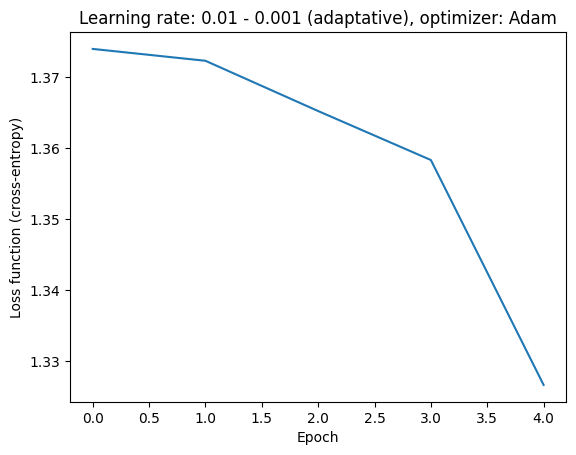

In [65]:
plot_loss(loss_list_val)

### Running inference again

In [112]:
trues, preds, loss_it_avg, cac_it_avg, loss_it, acc_it = inference("Test", test_loader, lstm)


Test loss: 1.031 
Test accuracy: 0.712


In [114]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
names = ['__dummy__', 'inform', 'question', 'directive', 'commissive']
names.remove('__dummy__') # dummy label is not interesting
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[1, 2, 3, 4]))

              precision    recall  f1-score   support

      inform       0.00      0.00      0.00      1272
    question       0.67      0.98      0.79      3522
   directive       0.81      0.92      0.86      2201
  commissive       0.00      0.00      0.00         0

   micro avg       0.71      0.79      0.75      6995
   macro avg       0.37      0.48      0.41      6995
weighted avg       0.59      0.79      0.67      6995



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
names = ['inform', 'question', 'directive', 'commissive']
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

### Fine-tuning BERT

In [ ]:
!pip install transformers

In [5]:
from transformers import AutoTokenizer

In [ ]:
bert_raw_dataset = load_dataset("silicone", "dyda_da")

In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples["Utterance"], padding="max_length", truncation=True)

bert_dataset = {}
bert_dataset['train'] = bert_raw_dataset['train'].map(tokenize_function, batched=True)
bert_dataset['validation'] = bert_raw_dataset['validation'].map(tokenize_function, batched=True)
bert_dataset['test'] = bert_raw_dataset['test'].map(tokenize_function, batched=True)

Map:   0%|          | 0/87170 [00:00<?, ? examples/s]

Map:   0%|          | 0/8069 [00:00<?, ? examples/s]

Map:   0%|          | 0/7740 [00:00<?, ? examples/s]

In [8]:
full_train_dataset = bert_dataset["train"].shuffle(seed=42)
full_eval_dataset = bert_dataset["validation"].shuffle(seed=42)

In [29]:
N, M = len(full_train_dataset), len(full_eval_dataset)

In [30]:
N, M

(87170, 8069)

In [39]:
train_dataloader = DataLoader(full_train_dataset, shuffle=True, batch_size=32)
validation_dataloader = DataLoader(full_eval_dataset, batch_size=32)

In [40]:
len(train_dataloader)

2725

In [ ]:
from transformers import AutoModelForSequenceClassification
# This model is equal to BERT + a linear layer for classification. In our custom model we designed a FastText/GloVe + a hidden layer and linear layer for classification
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=4)

In [11]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=1e-3)

In [33]:
from transformers import get_scheduler

num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [34]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

  0%|          | 0/2 [00:00<?, ?it/s]

In [45]:
L = len(train_dataloader)//4
print(L)

681


## Training/Evaluation loop

In [63]:
from datasets import load_metric
def eval_model():
  metric = load_metric("accuracy")
  model.eval()
  preds, trues = [], []
  for i, batch in tqdm(enumerate(validation_dataloader), desc="evaluating", total=validation_dataloader.__len__()):
      input_batch = {}
      input_batch["input_ids"] =  torch.transpose(torch.vstack(batch["input_ids"]), 0, 1)
      input_batch["attention_mask"] =  torch.transpose(torch.vstack(batch["attention_mask"]), 0, 1)
      input_batch["Labels"] = batch["Label"]
      with torch.no_grad():
          outputs = model(input_ids=input_batch["input_ids"], attention_mask=input_batch["attention_mask"], labels=input_batch["Labels"])

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      metric.add_batch(predictions=predictions, references=input_batch["Labels"])

      _, tag_seq  = torch.max(logits, 1)
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(input_batch['Labels'].cpu().detach().tolist())

  value = metric.compute()
  print(value)
  return value

In [17]:
from tqdm import tqdm

In [ ]:
model.train()
loss_history_per_epoch = []
all_metrics = {}
for epoch in range(num_epochs+1):
          # when epoch is done, compute the validation performance (accuracy)
          accuracy = eval_model()
          all_metrics[epoch] = accuracy
          # print(f"Epoch: {epoch}, validation accuracy: {accuracy.predictions}")
          model.train()
          print(f"Epoch: {epoch+1}/{num_epochs}")
          batch_count = -1
          num_batches = len(train_dataloader)
          loss_history = []
          for batch in train_dataloader:
                    batch_count += 1
                    if batch_count > 50:
                        break
                    if batch_count==num_batches-1:
                              loss_history_per_epoch.append(np.mean(loss_history))
                    print(f"Batch: {batch_count}/{num_batches}")
      
                    # batch is a dict with lists/batch of 4
                    input_batch = {}
                    input_batch["input_ids"] =  torch.transpose(torch.vstack(batch["input_ids"]), 0, 1)
                    input_batch["attention_mask"] =  torch.transpose(torch.vstack(batch["attention_mask"]), 0, 1)
                    input_batch["Labels"] = batch["Label"]
                    # print(k, v)
                    # batch = {k: v.to(device) )}
                    # batch_tensors = batch["input_ids"]
                    # batch_labels = batch["Label"]
                    # stack_batch =  torch.vstack(batch_tensors)
                    # stack_batch = torch.transpose(stack_batch, 0, 1)

                    # batch = {'Utterance': stack_batch.to('cuda'), 'Label': batch_labels.to('cuda')}
                    # batch = {k: v.to('cuda') for k, v in batch.items()}
                    outputs = model(input_ids=input_batch["input_ids"], attention_mask=input_batch["attention_mask"], labels=input_batch["Labels"])
                    # print(outputs)
                    loss = outputs.loss
                    loss_history.append(loss.item())
                    if batch_count%5==0:
                              print("Training loss: ", loss.item())
                    
                    loss.backward()
                    optimizer.step()
                    lr_scheduler.step()
                    optimizer.zero_grad()

evaluating:   0%|          | 0/253 [00:00<?, ?it/s]

{'accuracy': 0.6724501177345396}
Epoch: 1/2
Batch: 0/2725
Training loss:  0.4907621443271637
Batch: 1/2725
Batch: 2/2725
Batch: 3/2725
Batch: 4/2725
Batch: 5/2725
Training loss:  0.7957257032394409
Batch: 6/2725
Batch: 7/2725
Batch: 8/2725
Batch: 9/2725
Batch: 10/2725
Training loss:  0.7784836292266846
Batch: 11/2725
Batch: 12/2725
Batch: 13/2725
Batch: 14/2725
Batch: 15/2725
Training loss:  0.7919508218765259
Batch: 16/2725
Batch: 17/2725
Batch: 18/2725
Batch: 19/2725
Batch: 20/2725
Training loss:  0.6648922562599182
Batch: 21/2725
Batch: 22/2725
Batch: 23/2725
Batch: 24/2725
Batch: 25/2725
Training loss:  0.5932143330574036
Batch: 26/2725
Batch: 27/2725
Batch: 28/2725
Batch: 29/2725
Batch: 30/2725
Training loss:  0.9315425753593445
Batch: 31/2725
Batch: 32/2725
Batch: 33/2725
Batch: 34/2725
Batch: 35/2725
Training loss:  0.7869305610656738
Batch: 36/2725
Batch: 37/2725
Batch: 38/2725
Batch: 39/2725
Batch: 40/2725
Training loss:  0.5935690999031067
Batch: 41/2725
Batch: 42/2725
Batch:

evaluating:   0%|          | 0/253 [00:00<?, ?it/s]

{'accuracy': 0.6724501177345396}
Epoch: 2/2
Batch: 0/2725
Training loss:  0.7918825745582581
Batch: 1/2725
Batch: 2/2725
Batch: 3/2725
Batch: 4/2725
Batch: 5/2725
Training loss:  0.8335724472999573
Batch: 6/2725
Batch: 7/2725


In [50]:
len(all_metrics)

3

In [62]:
for value in all_metrics:
  print(f"After epoch {i}, the validation accuracy was: {value}")

ValueError: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

              precision    recall  f1-score   support

      inform       0.00      0.00      0.00       925
    question       0.53      0.01      0.02      1775
   directive       0.60      0.97      0.74      3125
  commissive       0.74      0.98      0.84      2244

    accuracy                           0.65      8069
   macro avg       0.47      0.49      0.40      8069
weighted avg       0.55      0.65      0.53      8069



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
